# Activitiy Clustering

In [51]:
import pandas as pd
import numpy as np
import pm4py
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
import warnings
import editdistance
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import LocalOutlierFactor
import jellyfish
import matplotlib.pyplot as plt
from math import floor, ceil

warnings.filterwarnings('ignore') # Remove warnings

In [55]:
#CASE_ID = "Auftragsnr.-Artikelnr."
CASE_ID = 'case'
ACTIVITY_ID = 'activity'

#df = pd.read_csv("../data/Auswertung_März_merged_Auftragsnr.-Artikelnr.csv", sep=";", dtype='unicode')
df = pd.read_csv("../../perfsky/data/daily.2019-July_September.csv", sep=",", dtype='unicode')
df = df[df[ACTIVITY_ID]!='AllTasks']

print('Data set contains:')
print('- ',len(df),'events')
print('- ',len(df['case'].unique()),'cases')
print('- ',len(df[ACTIVITY_ID].unique()),'activities')

avg_activities = df[CASE_ID].value_counts().mean()
print("- Avg. events per case: ", avg_activities)

# Convert to event log
df.rename(columns={CASE_ID: 'case:concept:name',
                   ACTIVITY_ID: 'concept:name',
                   "start_timestamp": "time:timestamp"}, inplace=True)
temp = dataframe_utils.convert_timestamp_columns_in_df(df)
log = log_converter.apply(temp)
df.head()

Data set contains:
-  61864 events
-  50 cases
-  261 activities
- Avg. events per case:  1237.28


,Unnamed: 0,case:concept:name,concept:name,start_time,end_time
1,1,daily.2019-09-24_05-05-02,DumpTask(sql_filename=regular_urls)(kvs=None)(chunk=prep),2019-09-24 05:20:10+00:00,2019-09-24 05:40:21+00:00
2,2,daily.2019-09-24_05-05-02,DumpTask(sql_filename=reprocess_urls)(kvs=None)(chunk=prep),2019-09-24 05:20:10+00:00,2019-09-24 05:21:03+00:00
3,3,daily.2019-09-24_05-05-02,DumpTask(sql_filename=daily_urls)(kvs=None)(chunk=prep),2019-09-24 05:20:10+00:00,2019-09-24 05:21:32+00:00
4,4,daily.2019-09-24_05-05-02,ProxySetupTask,2019-09-24 05:20:10+00:00,2019-09-24 05:32:45+00:00
5,5,daily.2019-09-24_05-05-02,CrawlFeedTask,2019-09-24 05:20:10+00:00,2019-09-24 05:43:43+00:00


In [56]:
# Parameters

TRACE_SETS = False
DISTANCE = "edit" # "jaro", "dam_lev", "lev", "lcs", "edit", "lev"
ALGORITHM = "agglomerative" # "agglomerative", "dbscan"
N_CLUSTERS = 75

# Used for Agglomerative Clustering
# ‘average’ uses the average of the distances of each observation of the two sets.
# ‘complete’ or ‘maximum’ linkage uses the maximum distances between all observations of the
# ‘ward’ minimizes the variance of the clusters being merged. two sets.
#‘ single’ uses the minimum of the distances between all observations of the two sets.
LINKAGE = "complete" # "ward", "complete", "average", "single"

In [57]:
from pm4py.statistics.traces.generic.log import case_statistics

variants_count = case_statistics.get_variant_statistics(log)
variants_table = pd.DataFrame.from_dict(variants_count)
variants_table['variant_list'] = variants_table.apply(lambda x: x['variant'].split(','), axis=1)
#print(len(variants_table))
#variants_table.head()

In [58]:
activities = variants_table['variant_list']

In [59]:
# Dynamic Programming implementation of LCS problem
def lcs_dist(X, Y):
    # find the length of the strings
    m = len(X)
    n = len(Y)
 
    # declaring the array for storing the dp values
    L = [[None]*(n + 1) for i in range(m + 1)]
 
    """Following steps build L[m + 1][n + 1] in bottom up fashion
    Note: L[i][j] contains length of LCS of X[0..i-1]
    and Y[0..j-1]"""
    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0 or j == 0 :
                L[i][j] = 0
            elif X[i-1] == Y[j-1]:
                L[i][j] = L[i-1][j-1]+1
            else:
                L[i][j] = max(L[i-1][j], L[i][j-1])
 
    # L[m][n] contains the length of LCS of X[0..n-1] & Y[0..m-1]
    return L[m][n]

def lev_dist(a, b):
    '''
    This function will calculate the levenshtein distance between two input
    strings a and b
    
    params:
        a (String) : The first string you want to compare
        b (String) : The second string you want to compare
        
    returns:
        This function will return the distnace between string a and b.
        
    example:
        a = 'stamp'
        b = 'stomp'
        lev_dist(a,b)
        >> 1.0
    '''
    
    def min_dist(s1, s2):

        if s1 == len(a) or s2 == len(b):
            return len(a) - s1 + len(b) - s2

        # no change required
        if a[s1] == b[s2]:
            return min_dist(s1 + 1, s2 + 1)

        return 1 + min(
            min_dist(s1, s2 + 1),      # insert character
            min_dist(s1 + 1, s2),      # delete character
            min_dist(s1 + 1, s2 + 1),  # replace character
        )

    return min_dist(0, 0)

"""
Compute the Damerau-Levenshtein distance between two given
strings (s1 and s2)
"""
def damerau_levenshtein_distance(s1, s2):
    d = {}
    lenstr1 = len(s1)
    lenstr2 = len(s2)
    for i in range(-1,lenstr1+1):
        d[(i,-1)] = i+1
    for j in range(-1,lenstr2+1):
        d[(-1,j)] = j+1

    for i in range(lenstr1):
        for j in range(lenstr2):
            if s1[i] == s2[j]:
                cost = 0
            else:
                cost = 1
            d[(i,j)] = min(
                           d[(i-1,j)] + 1, # deletion
                           d[(i,j-1)] + 1, # insertion
                           d[(i-1,j-1)] + cost, # substitution
                          )
            if i and j and s1[i]==s2[j-1] and s1[i-1] == s2[j]:
                d[(i,j)] = min (d[(i,j)], d[i-2,j-2] + cost) # transposition
    
    return d[lenstr1-1,lenstr2-1]

 
# Function to calculate the Jaro Similarity of two array
def jaro_distance(s1, s2):
     
    # If the s are equal
    if (s1 == s2):
        return 1.0
 
    # Length of two s
    len1 = len(s1)
    len2 = len(s2)
 
    # Maximum distance upto which matching
    # is allowed
    max_dist = floor(max(len1, len2) / 2) - 1
 
    # Count of matches
    match = 0
 
    # Hash for matches
    hash_s1 = [0] * len(s1)
    hash_s2 = [0] * len(s2)
 
    # Traverse through the first
    for i in range(len1):
 
        # Check if there is any matches
        for j in range(max(0, i - max_dist),
                       min(len2, i + max_dist + 1)):
             
            # If there is a match
            if (s1[i] == s2[j] and hash_s2[j] == 0):
                hash_s1[i] = 1
                hash_s2[j] = 1
                match += 1
                break
 
    # If there is no match
    if (match == 0):
        return 0.0
 
    # Number of transpositions
    t = 0
    point = 0
 
    # Count number of occurrences
    # where two characters match but
    # there is a third matched character
    # in between the indices
    for i in range(len1):
        if (hash_s1[i]):
 
            # Find the next matched character
            # in second
            while (hash_s2[point] == 0):
                point += 1
 
            if (s1[i] != s2[point]):
                t += 1
            point += 1
    t = t//2
 
    # Return the Jaro Similarity
    return (match/ len1 + match / len2 +
            (match - t) / match)/ 3.0

In [60]:
activities = df['concept:name'].unique()

In [61]:
def compute_distance_matrix(variants, distance=DISTANCE):
    #tid = [','.join(x) for x in variants.tolist()]
    tid = variants
    distance_matrix = []
    for i, variant in enumerate(variants):
        distances_per_source = []            
        if i > 0:
            distances_per_source.extend([-1 for v in range(i)])
        if i == len(variants):
            distances_per_source.append(0)
            distance_matrix.append(distances_per_source)
        else:
            for j, successor in enumerate(variants[i:]):
                if distance == "edit":
                    distances_per_source.append(editdistance.eval(variant, successor))
                elif distance == "lcs":
                    distances_per_source.append(lcs_dist(variant, successor))
                elif distance == "lev":
                    distances_per_source.append(lev_dist(variant, successor))
                elif distance == "dam_lev":
                    distances_per_source.append(damerau_levenshtein_distance(variant, successor))
                elif distance == "jaro": 
                    distances_per_source.append(jaro_distance(variant, successor))
                else:
                    raise ValueError("Unkonw distance")
                    
            distance_matrix.append(distances_per_source)        
    distance_matrix= np.array(distance_matrix)
    iu = np.triu_indices(len(variants),1)
    il = (iu[1],iu[0])
    distance_matrix[il]=distance_matrix[iu]

    return distance_matrix, tid 
                                    

if TRACE_SETS:
    variants = variants_table['variant_list']
    variants = variants.apply(lambda v: list(set(v))).drop_duplicates()
else:
    variants = variants_table['variant_list']
    
distance_matrix, tid  = compute_distance_matrix(activities, DISTANCE)
print(len(tid))
print(distance_matrix.shape)

261
(261, 261)


In [62]:
print(len(distance_matrix), len(distance_matrix[0]))
distance_matrix

261 261


array([[ 0,  7,  6, ..., 43, 45, 53],
       [ 7,  0,  9, ..., 46, 47, 55],
       [ 6,  9,  0, ..., 41, 43, 51],
       ...,
       [43, 46, 41, ...,  0,  8, 17],
       [45, 47, 43, ...,  8,  0, 15],
       [53, 55, 51, ..., 17, 15,  0]])

In [63]:
clustering = AgglomerativeClustering(linkage=LINKAGE, affinity='precomputed', n_clusters=N_CLUSTERS).fit(distance_matrix)
clustering.labels_

array([11, 62, 11, 16, 61, 11, 45,  9, 16, 10,  9, 56,  9, 58,  8,  8,  6,
        6, 10,  9, 67, 30, 10,  9, 10,  9, 39,  3, 53,  3,  3,  0,  0,  0,
       74,  0, 74, 25, 25,  2,  2, 10,  9, 10,  9, 10,  9, 10,  9, 46,  9,
       10,  9, 10,  9, 10,  9,  9, 10, 10,  9, 10,  9,  2,  2, 10,  9, 10,
        9, 10,  9, 10,  9, 10,  9, 10,  9, 10,  9, 10,  9, 10,  9, 10,  9,
       10,  9, 10,  9, 10,  9, 10,  9, 10,  9, 10,  9, 10,  9, 10,  9, 10,
        9, 10, 19, 19, 18, 19, 18, 10, 54, 18, 71, 10, 69, 52, 69,  1, 50,
        1, 63, 42,  4,  4, 36, 59, 48,  5,  5, 32, 32, 15, 15, 55,  3, 34,
       41, 13, 28, 66, 72, 43, 21, 70, 23, 73, 57, 29, 31, 47,  7, 49, 23,
       44, 64, 37, 24, 68, 40, 65,  7, 14, 51, 27, 26, 35,  2,  0, 28,  0,
       74, 69, 17, 25, 12, 60, 33,  7,  2, 12, 20, 20, 13, 36,  3, 48, 34,
       41, 13, 28, 72, 66, 43, 21, 70, 23, 73, 57, 31, 29, 47,  7, 49, 23,
       44, 64, 37, 24, 40, 68, 65,  7, 14, 51, 27, 26, 35, 28, 17, 12,  7,
       33, 13, 36, 38,  3

In [64]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Children of hierarchical clustering
    children = model.children_
    #print(children[N_CLUSTERS])

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])
    #print(distance[N_CLUSTERS])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)
    #print(no_of_observations[N_CLUSTERS])

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
    #print(linkage_matrix)
    
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Applying clustering


<Figure size 432x288 with 0 Axes>

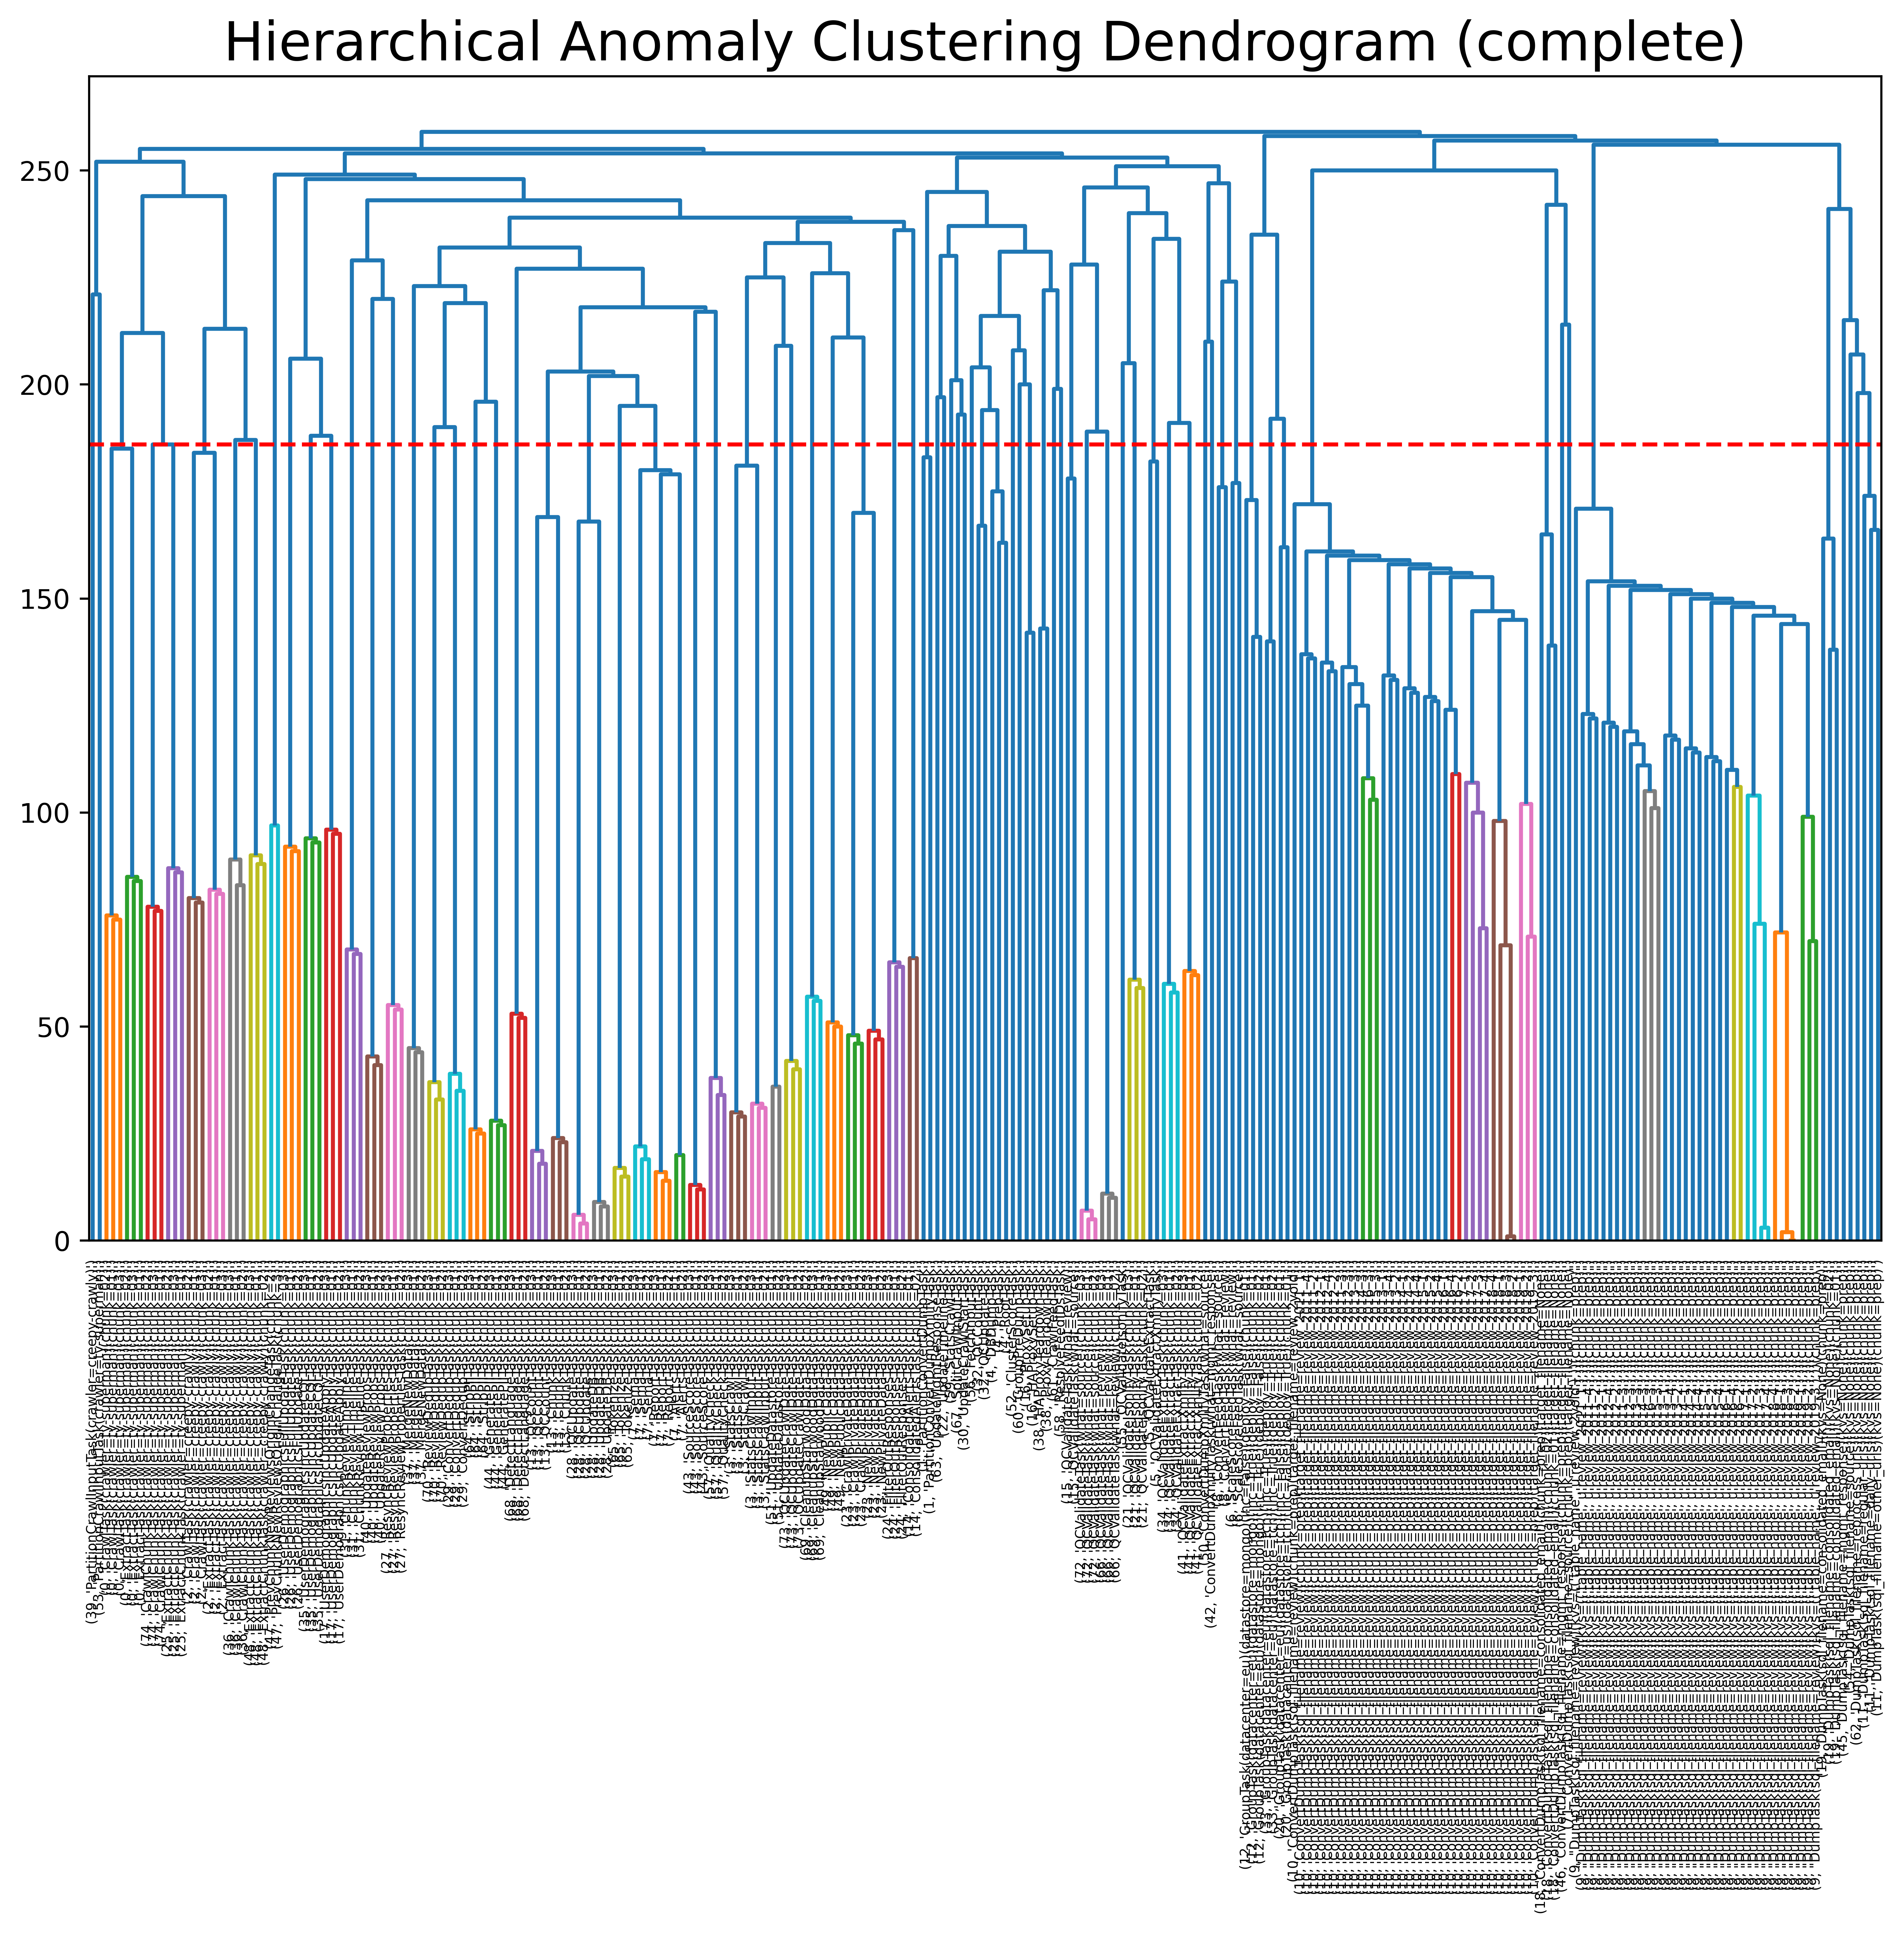


DONE


<Figure size 432x288 with 0 Axes>

In [65]:
dist_matrix = distance_matrix
tids = tid


print("Applying clustering")
#print(dist_matrix.shape)
tracs_clusters_labeled = list(zip(clustering.labels_, tids))
#print("Trace Clusters", tracs_clusters_labeled)
#print(tracs_clusters_labeled)

plt.clf()
# plotting
plt.figure(figsize=(12,8), dpi=600)
plt.title(f'Hierarchical Anomaly Clustering Dendrogram ({LINKAGE})', fontsize=20)
plot_dendrogram(clustering, labels=tracs_clusters_labeled, color_threshold=110)
plt.axhline(y=len(dist_matrix)-N_CLUSTERS, color='r', linestyle='--')
plt.show()
#plt.savefig('../plots/dendrogram_anomaly.png')
plt.clf()

print("\nDONE")

In [66]:
def find_matching_key(list_in, max_key_only = True):
  """
  returns the longest matching key in the list * with the highest frequency
  """
  keys = {}
  curr_key = ''

  # If n does not exceed max_n, don't bother adding
  max_n = 0

  for word in list(set(list_in)): #get unique values to speed up
    for i in range(len(word)):
      # Look up the whole word, then one less letter, sequentially
      curr_key = word[0:len(word)-i]
      # if not in, count occurance
      if curr_key not in keys.keys() and curr_key!='':
        n = 0
        for word2 in list_in:
          if curr_key in word2:
            n+=1
        # if large n, Add to dictionary
        if n > max_n:
          max_n = n
          keys[curr_key] = n
    # Finish the word
  # Finish for loop  
  if max_key_only:
    return max(keys, key=keys.get)
  else:
    return keys    

In [67]:
print(len(tracs_clusters_labeled))
tracs_clusters_labeled[:5]
clusters = pd.DataFrame(tracs_clusters_labeled, columns = ['cluster_id', 'concept:name'])
clusters.sort_values(by='cluster_id').head()

261


,cluster_id,concept:name
33,0,ExtractTask(crawler=ty-superman)(chunk=03)
167,0,CrawlTask(crawler=ty-superman)(chunk=02)
32,0,CrawlTask(crawler=ty-superman)(chunk=03)
35,0,ExtractTask(crawler=ty-superman)(chunk=01)
31,0,CrawlTask(crawler=ty-superman)(chunk=01)


In [68]:
pd.set_option('display.max_colwidth', None)

def get_cluster_name(cluster):
    if cluster['cluster_id'].unique() == [-1]:
        return 'NOISE'
    else:
        #print("Cluster:", cluster['cluster_id'].unique(), find_matching_key(cluster['concept:name']), "\n", cluster['concept:name'])
        return find_matching_key(cluster['concept:name'])+'_'+str(cluster['cluster_id'].unique()[0])

new_names = pd.DataFrame(clusters.groupby('cluster_id').apply(get_cluster_name), columns = ['common_act'])
new_names = new_names.join(clusters.set_index('cluster_id'), on='cluster_id').reset_index()

new_names.head()

,cluster_id,common_act,concept:name
0,0,CrawlTask(crawler=ty-superman)(chunk=0_0,CrawlTask(crawler=ty-superman)(chunk=01)
1,0,CrawlTask(crawler=ty-superman)(chunk=0_0,CrawlTask(crawler=ty-superman)(chunk=03)
2,0,CrawlTask(crawler=ty-superman)(chunk=0_0,ExtractTask(crawler=ty-superman)(chunk=03)
3,0,CrawlTask(crawler=ty-superman)(chunk=0_0,ExtractTask(crawler=ty-superman)(chunk=01)
4,0,CrawlTask(crawler=ty-superman)(chunk=0_0,CrawlTask(crawler=ty-superman)(chunk=02)


In [69]:
#df = df.reset_index()
match = df.join(new_names.set_index('concept:name'),  on='concept:name')
match.rename(columns={'case:concept:name':CASE_ID,
                   'concept:name':ACTIVITY_ID,
                   "time:timestamp": "start_timestamp"}, inplace=True)
match = match[['case', 'activity', 'start_time',
       'end_time', 'cluster_id', 'common_act']]

if len(match[match['common_act'].isnull()])==0:
    print("No common activity for",len(match['common_act'].unique()),"activities in ", len(match), " rows are empty.")

match['start_time']=match['start_time'].apply(lambda x: str(x).split('+')[0])
match['end_time']=match['end_time'].apply(lambda x: str(x).split('+')[0])

match.to_csv("../../perfsky/data/clustered_agg_edit_"+str(N_CLUSTERS)+"_daily.csv", sep=";",index=False)
match.sort_values(by='common_act')

No common activity for 75 activities in  61864  rows are empty.


,case,activity,start_time,end_time,cluster_id,common_act
26451,daily.2019-08-03_20-09-01,QCCountTask(chunk=01),2019-08-04 06:57:08,2019-08-04 07:04:20,13,C_13
41444,daily.2019-07-13_21-50-01,QCCountTask(chunk=01),2019-07-14 06:14:39,2019-07-14 06:21:07,13,C_13
20655,daily.2019-07-29_16-03-01,ChunkTask(chunk=01),2019-07-31 02:39:02,2019-07-31 02:39:11,13,C_13
50211,daily.2019-08-21_18-17-01,QCCountTask(chunk=01),2019-08-22 04:37:09,2019-08-22 04:44:38,13,C_13
29443,daily.2019-08-20_00-31-01,ChunkTask(chunk=03),2019-08-21 18:14:57,2019-08-21 18:15:11,13,C_13
...,...,...,...,...,...,...
59391,daily.2019-08-26_20-10-01,UserDemographicsIncUpdateCQLTask(chunk=02),2019-08-28 12:06:10,2019-08-28 12:20:51,35,UserDemographicsIncUpdateCQLTask(chunk=0_35
30317,daily.2019-08-02_01-58-01,UserDemographicsIncUpdateCQLTask(chunk=01),2019-08-02 18:29:07,2019-08-02 18:34:35,35,UserDemographicsIncUpdateCQLTask(chunk=0_35
52819,daily.2019-08-11_05-05-01,UserDemographicsIncUpdateCQLTask(chunk=01),2019-08-11 21:07:17,2019-08-11 21:11:27,35,UserDemographicsIncUpdateCQLTask(chunk=0_35
40374,daily.2019-09-13_04-11-01,UserDemographicsIncUpdateCQLTask(chunk=01),2019-09-13 23:28:24,2019-09-13 23:34:39,35,UserDemographicsIncUpdateCQLTask(chunk=0_35


# DBSCAN

In [70]:
from sklearn.cluster import DBSCAN
MIN_SAMPLES = 10
EPS=80

clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(distance_matrix)
clustered_obj = [a for a in clustering.labels_ if a > -1]
print(len(clustered_obj))

print(clustering.labels_)


217
[-1 -1 -1  0  0 -1 -1  1  0  2  1  0  1  0 -1 -1 -1 -1  2  1  0  0  2  1
  2  1 -1  3 -1  3  3  4  4  4  4  4  4  4  4  4  4  2  1  2  1  2  1  2
  1 -1  1  2  1  2  1  2  1  1  2  2  1  2  1  4  4  2  1  2  1  2  1  2
  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2
  1  2  1  2  1  2  1  2 -1 -1 -1 -1 -1  2 -1 -1 -1  2  3  0  3  0 -1  0
  0 -1  0  0  4  0  4  0  0  0  0 -1  0  0  3  3  3  3  3 -1  3  3  3  3
  3  3  3  3  3 -1  3  3  3  3  3  3  3  3  3  3  3  3  3  3 -1 -1  4  4
  3  4  4  3 -1  4 -1  0 -1  3  4 -1 -1 -1  3  4  3  4  3  3  3  3  3 -1
  3  3  3  3  3  3  3  3 -1  3  3  3  3  3  3  3  3  3  3  3  3  3  3 -1
 -1  3 -1 -1  3 -1  3  4  0  3  0  4  3  3  3  3 -1  3  3  3  3  3  3  3
  3  3  3  3  3  3  0  3  3  3  3  3  3  3  3 -1 -1 -1  3  3  0]


<Figure size 432x288 with 0 Axes>

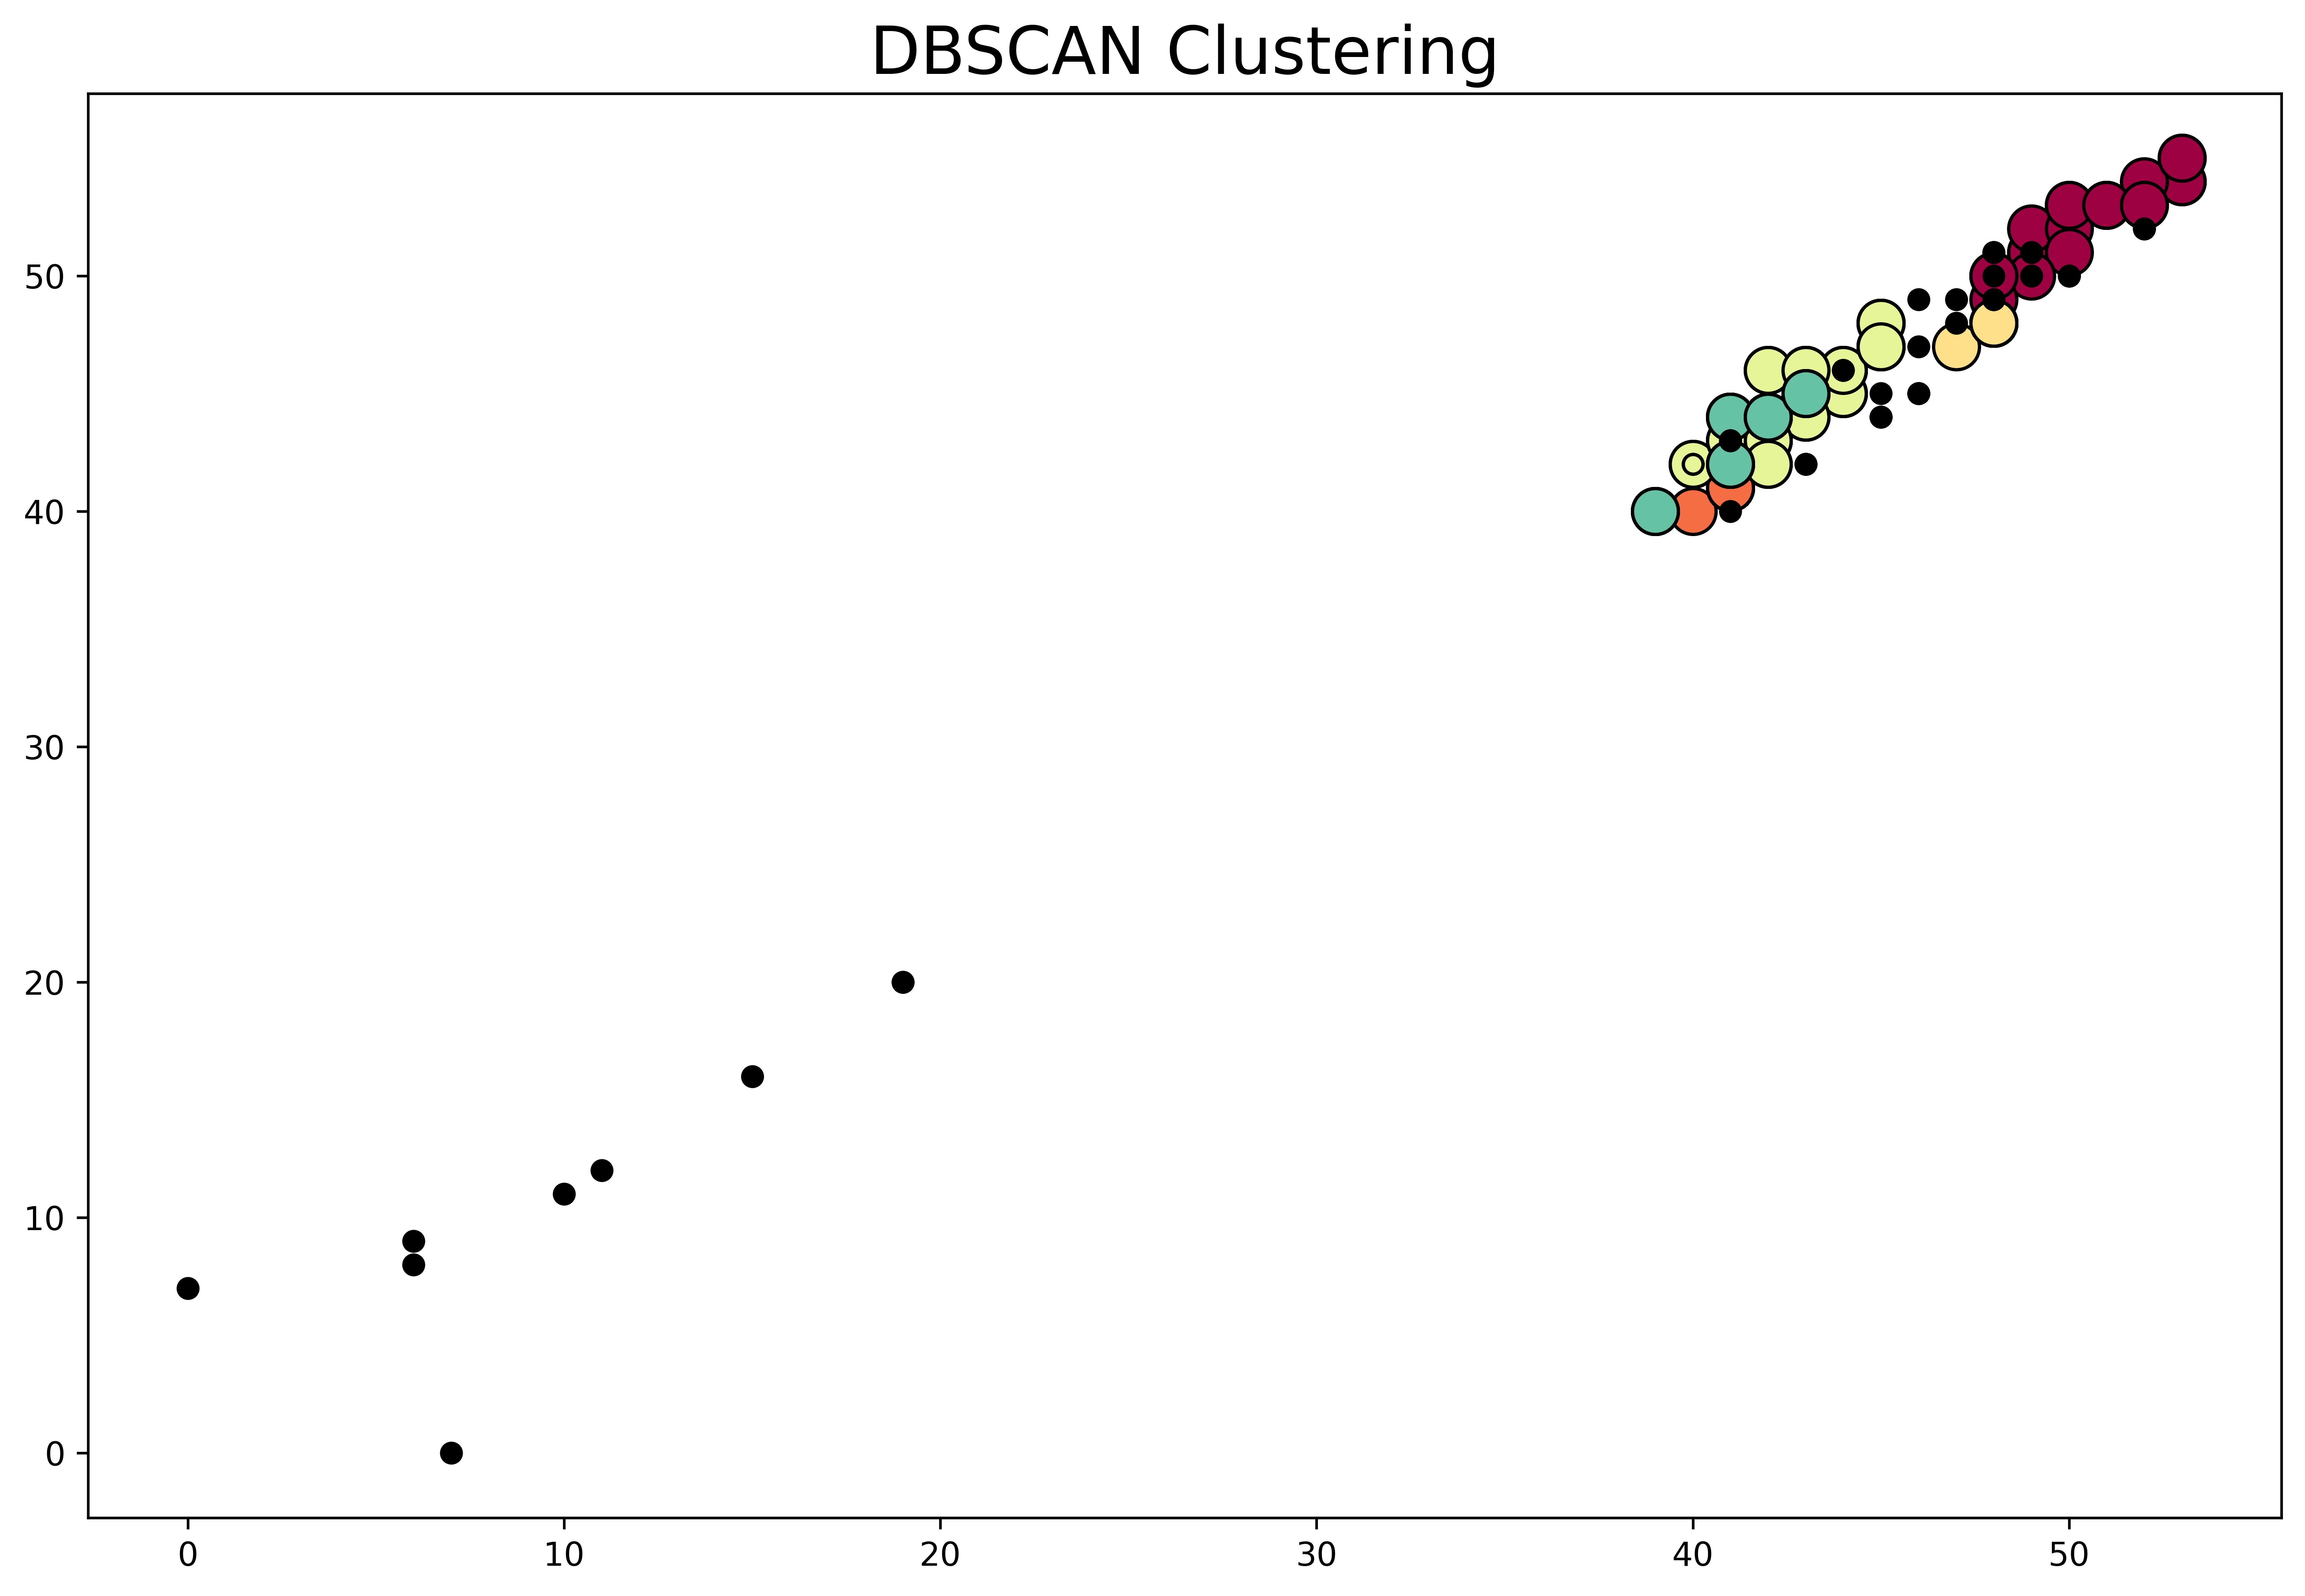

<Figure size 432x288 with 0 Axes>

In [71]:
labels = clustering.labels_
X = distance_matrix
core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True

plt.clf()
plt.figure(figsize=(12,8), dpi=600)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

plt.title("DBSCAN Clustering", fontsize=20)
#plt.savefig('../plots/dendrogram_anomaly.png')
plt.show()
plt.clf()

In [72]:
clusters_labeled = list(zip(clustering.labels_, tids))

In [73]:
clusters = pd.DataFrame(clusters_labeled, columns = ['cluster_id', 'concept:name'])
clusters.head()

new_names = pd.DataFrame(clusters.groupby('cluster_id').apply(get_cluster_name), columns = ['common_act'])
new_names = new_names.join(clusters.set_index('cluster_id'), on='cluster_id').reset_index()

new_names.head()

,cluster_id,common_act,concept:name
0,-1,NOISE,DumpTask(sql_filename=regular_urls)(kvs=None)(chunk=prep)
1,-1,NOISE,DumpTask(sql_filename=reprocess_urls)(kvs=None)(chunk=prep)
2,-1,NOISE,DumpTask(sql_filename=daily_urls)(kvs=None)(chunk=prep)
3,-1,NOISE,DumpTask(sql_filename=other_urls)(kvs=None)(chunk=prep)
4,-1,NOISE,DumpTask(sql_filename=mgmt_response)(kvs=None)(chunk=prep)


In [74]:
match = df.join(new_names.set_index('concept:name'),  on='concept:name')
match.rename(columns={'case:concept:name':CASE_ID,
                   'concept:name':ACTIVITY_ID,
                   "time:timestamp": "start_timestamp"}, inplace=True)
match = match[['case', 'activity', 'start_time',
       'end_time', 'cluster_id', 'common_act']]

if len(match[match['common_act'].isnull()])==0:
    print("Success for",len(match['common_act'].unique()),"activities in ", len(match), " rows")

match['start_time'] = match['start_time'].apply(lambda x: str(x).split('+')[0])
match['end_time'] = match['end_time'].apply(lambda x: str(x).split('+')[0])
match['common_act'] = match.apply(lambda x: x['activity'] if x['common_act']=='NOISE' else x['common_act'], axis=1)

match.to_csv("../../perfsky/data/clustered_dbscan_"+DISTANCE+"_eps"+str(EPS)+"_ms"+str(MIN_SAMPLES)+"_daily.csv", sep=";",index=False)
#match.sort_values(by='common_act')
match

Success for 6 activities in  61864  rows


,case,activity,start_time,end_time,cluster_id,common_act
1,daily.2019-09-24_05-05-02,DumpTask(sql_filename=regular_urls)(kvs=None)(chunk=prep),2019-09-24 05:20:10,2019-09-24 05:40:21,-1,DumpTask(sql_filename=regular_urls)(kvs=None)(chunk=prep)
2,daily.2019-09-24_05-05-02,DumpTask(sql_filename=reprocess_urls)(kvs=None)(chunk=prep),2019-09-24 05:20:10,2019-09-24 05:21:03,-1,DumpTask(sql_filename=reprocess_urls)(kvs=None)(chunk=prep)
3,daily.2019-09-24_05-05-02,DumpTask(sql_filename=daily_urls)(kvs=None)(chunk=prep),2019-09-24 05:20:10,2019-09-24 05:21:32,-1,DumpTask(sql_filename=daily_urls)(kvs=None)(chunk=prep)
4,daily.2019-09-24_05-05-02,ProxySetupTask,2019-09-24 05:20:10,2019-09-24 05:32:45,0,C_0
5,daily.2019-09-24_05-05-02,CrawlFeedTask,2019-09-24 05:20:10,2019-09-24 05:43:43,0,C_0
...,...,...,...,...,...,...
61909,daily.2019-08-28_20-16-01,ChunkTask(chunk=02),2019-08-30 12:52:32,2019-08-30 12:52:40,3,T_3
61910,daily.2019-08-28_20-16-01,UserDemographicsIncUpdateApplyTask(chunk=03),2019-08-30 12:58:12,2019-08-30 12:59:42,-1,UserDemographicsIncUpdateApplyTask(chunk=03)
61911,daily.2019-08-28_20-16-01,UpdateDBTask(chunk=03),2019-08-30 13:17:25,2019-08-30 13:43:00,3,T_3
61912,daily.2019-08-28_20-16-01,ChunkTask(chunk=03),2019-08-30 13:43:00,2019-08-30 13:43:14,3,T_3
